# Beijing Air-Quality Time Series Project
### Modeling Time Series

by Dolci Sanders and Paul Torres



In [31]:
import pandas as pd
import numpy as np



from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima

from pmdarima import auto_arima    # for determining ARIMA orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import savefig 
import pickle




# Styling Guide 
plt.style.use('fivethirtyeight')
sns.set_palette(sns.diverging_palette(250,700, s= 70 , l= 10, n= 12))

import warnings
warnings.filterwarnings("ignore")

## Read in pickle, check index for date time

In [5]:
train = pd.read_pickle('PKL/train.pkl')
test = pd.read_pickle('PKL/test.pkl')
time = pd.read_pickle('PKL/time.pkl')

In [6]:
train.index

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00',
               '2013-03-01 02:00:00', '2013-03-01 03:00:00',
               '2013-03-01 04:00:00', '2013-03-01 05:00:00',
               '2013-03-01 06:00:00', '2013-03-01 07:00:00',
               '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2016-03-26 04:00:00', '2016-03-26 05:00:00',
               '2016-03-26 06:00:00', '2016-03-26 07:00:00',
               '2016-03-26 08:00:00', '2016-03-26 09:00:00',
               '2016-03-26 10:00:00', '2016-03-26 11:00:00',
               '2016-03-26 12:00:00', '2016-03-26 13:00:00'],
              dtype='datetime64[ns]', name='Date', length=323016, freq=None)

In [7]:
train.index = pd.DatetimeIndex(train.index).to_period('D')
test.index = pd.DatetimeIndex(test.index).to_period('D')

In [8]:
train = train.drop(columns=['station'], axis = 1)
test = test.drop(columns=['station'], axis = 1)

In [9]:
train.index

PeriodIndex(['2013-03-01', '2013-03-01', '2013-03-01', '2013-03-01',
             '2013-03-01', '2013-03-01', '2013-03-01', '2013-03-01',
             '2013-03-01', '2013-03-01',
             ...
             '2016-03-26', '2016-03-26', '2016-03-26', '2016-03-26',
             '2016-03-26', '2016-03-26', '2016-03-26', '2016-03-26',
             '2016-03-26', '2016-03-26'],
            dtype='period[D]', name='Date', length=323016, freq='D')

In [10]:
from pmdarima.arima.utils import ndiffs

In [9]:
## Adf Test
print(ndiffs(train, test='adf')) 

# KPSS test
print(ndiffs(train, test='kpss'))

# PP test:
print(ndiffs(train, test='pp'))

0
1
0


In [ ]:
stepwise_fit = auto_arima(train['PM2.5'], start_p=0, start_q=0,
                         max_p=2, max_q=2, m=12,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   # we don't want to know if an order does not work
                         suppress_warnings=True,  # we don't want convergence warnings
                         stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=305.84 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2860014.559, Time=18.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2848894.561, Time=137.59 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2848392.128, Time=97.98 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2860012.559, Time=4.69 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2848464.607, Time=23.80 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=416.89 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2848299.221, Time=336.94 sec


In [13]:
auto_arima(train['PM2.5'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               323016
Model:               SARIMAX(0, 1, 1)   Log Likelihood            -1424229.303
Date:                Thu, 10 Sep 2020   AIC                        2848462.607
Time:                        13:42:46   BIC                        2848483.978
Sample:                             0   HQIC                       2848468.769
                             - 323016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1908      0.000    560.819      0.000       0.190       0.191
sigma2       395.6847      0.153   2578.546      0.000     395.384     395.985
===================================================================================
Ljung-Box (Q):                     3687.90   Jarque-Bera (JB):         104919298.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.97
Prob(H) (two-sided):                  0.31   Kurtosis:                        91.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model_PM = SARIMAX(train['PM2.5'],order=(0,0,1))
results = model_PM.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:               323016
Model:               SARIMAX(0, 0, 1)   Log Likelihood            -1797770.956
Date:                Thu, 10 Sep 2020   AIC                        3595545.912
Time:                        13:31:44   BIC                        3595567.283
Sample:                             0   HQIC                       3595552.074
                             - 323016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9062      0.000   2093.844      0.000       0.905       0.907
sigma2      3996.9101      5.890    678.591      0.000    3985.366    4008.454
===================================================================================
Ljung-Box (Q):                  2468308.68   Jarque-Bera (JB):            897835.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
#Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions_PM = results.predict(start=start, end=end, dynamic=False).rename('SARIMAX(0,0,1) Predictions')

In [17]:
for i in range(len(predictions_PM)):
    print(f"predicted={predictions_PM[i]:<19}, expected={test['PM2.5'][i]}")


KeyError: 0

TypeError: index type not supported

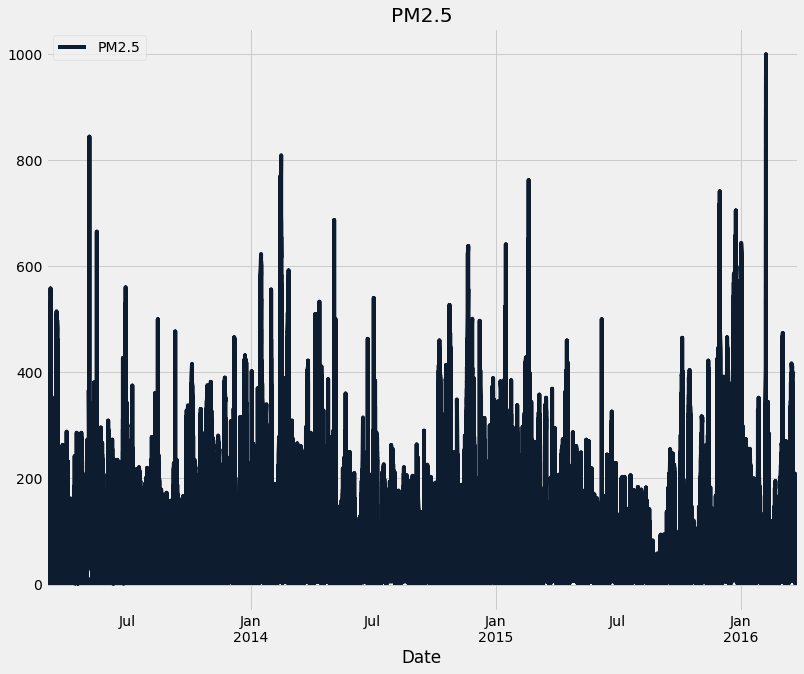

In [33]:

ax = train['PM2.5'].plot(legend=True,figsize=(12,10),title= 'PM2.5')
ylabel= 'PM 2.5'
xlabel='' # we don't really need a label here
predictions_PM.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [ ]:
# Metrics

error = mean_squared_error(test['PM2.5'], predictions_PM)
print(f'SARIMAX(0,0,1) MSE Error: {error:18}')
error = rmse(test['PM2.5'], predictions_PM)
print(f'SARIMAX(0,0,1) RMSE Error: {error:18}')

In [34]:
model_PM = SARIMAX(df['PM'],order=(0,0,1))
results = model_PM.fit()
fcast_PM = results.predict(len(df),len(df)+18).rename('SARIMAX(0,0,1) Forecast')
# Plot predictions against known values
title = 'Forecasted PM 2.5 Level'
ylabel='PM 2.5'
xlabel='' # we don't really need a label here
ax = test['Pm2.5'].plot(legend=True,figsize=(12,6),title=title)
fcast_PM.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

NameError: name 'df' is not defined